This notebook will be used to develop the reference values that will be measured by the temperature, pressure and flow sensors. The reference values will be transformed on the sensor simulator to emulate its measurements for a normal operation and fault conditions, such as overpressure and high decay rates.

First of all, we need to import the necessary libraries and define the constants that will be used in the simulation.

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [61]:
def interpolate_with_noise(values, step=0.05, noise_level=0.1):
    interpolated_values = []
    for i in range(len(values) - 1):
        # Unpack the current and next tuple
        (t1, temp1), (t2, temp2) = values[i], values[i + 1]

        # Calculate the number of steps between the two times
        steps = range(1, int(round((t2 - t1) / step)))

        # Find the temperature difference and set a minimum difference threshold
        temps_diff = max(math.fabs(temp2 - temp1), 0.05)

        # Modify the noise level based on the temperature difference
        # The noise level is higher for smaller differences and lower for larger differences
        adjusted_noise_level = noise_level / (1 + temps_diff)

        # Generate the intermediate values with noise
        for i, s in enumerate(steps, start=1):
            # Calculate the intermediate time
            current_time = t1 + s * step

            # Linear interpolation formula
            current_temp = temp1 + ((temp2 - temp1) / (t2 - t1)) * (current_time - t1)

            denominator = math.exp(-i + 1) + 1.5

            # Introduce noise
            noise = random.uniform(-adjusted_noise_level/denominator, adjusted_noise_level/denominator)
            current_temp_with_noise = current_temp + noise

            # Append the interpolated value to the list
            interpolated_values.append((round(current_time, 2), current_temp_with_noise))

        # Add the last value of the current interval if it's not the last tuple
        if i < len(values) - 2:
            interpolated_values.append((t2, temp2 + random.uniform(-adjusted_noise_level, adjusted_noise_level)))

    # Append the last value of the entire sequence with noise
    final_time, final_temp = values[-1]
    interpolated_values.append((final_time, final_temp + random.uniform(-adjusted_noise_level, adjusted_noise_level)))

    return interpolated_values

def draw_plot(x, y, title, xlabel, ylabel, color, size_multiplier=(1, 1)):
    # Plotting the graph

    x_mult, y_mult = size_multiplier
    
    if x_mult != 1:
        x_mult = 3 if x_mult > 3 else x_mult
        plt.figure().set_figwidth(6.4*x_mult)

    if y_mult != 1:
        y_mult = 3 if y_mult > 3 else y_mult
        plt.figure().set_figheight(4.8*y_mult)
        
    plt.plot(x, y, label=title, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    plt.ylim(0, None)
    plt.xlim(0, None)
    plt.legend()
    plt.show()
    
def repeat_values_n_times(values, N):

    if N <= 1:
        return values

    timestamp_increment = values[-1][0]
    
    # Initialize the result array with the original air_flow_values
    result = values[:]
    
    for i in range(1, N):
        # Create the new repeated sequence, adjusting timestamps with the increment
        new_sequence = [(t + i * timestamp_increment, v) for t, v in values[1:]]
        # Append the new sequence to the result
        result.extend(new_sequence)
    
    return result

def draw_values_graph(values = [], repeat:int = 1, step:float = 0.05, noise_level:float = 0.1, func = interpolate_with_noise, type = 'flow', title = ''):
    """
    type: 'flow', 'pressure', 'temperature'
    """

    values = repeat_values_n_times(values, repeat)

    interpolated_values = func(values, step, noise_level)

    # Separate the time and values for plotting
    times = [time for time, _ in interpolated_values]
    temperatures = [temp for _, temp in interpolated_values]

    xlabel = 'Time (s)'
    ylabel = ''
    color = 'blue'
    match type:
        case 'flow':
            ylabel = 'L/min'
            title = 'Reference Air Flow' if title == '' else title
        case 'pressure':
            ylabel = 'MPa'
            title = 'Reference Pressure' if title == '' else title
            color = 'green'
        case 'temperature':
            ylabel = 'T °C'
            title = 'Reference Temperature' if title == '' else title
            color = 'red'

    draw_plot(times, temperatures, title, xlabel, ylabel, color, size_multiplier=(repeat, 1))

In [62]:
air_flow_values = [
    (0, 0.3),
    (0.4, 0.3),
    (0.6, 3.3),
    (0.7, 2.2),
    (1.7, 1.7),
    (2.2, 1.6),
    (2.7, 1.7),
    (3.5, 1.6),
    (5, 1.6),
    (5.5, 1),
    (6, 0.7),
    (7, 0.3),
    (10, 0.3)
]

temperature_values = [
    (0, 26),
    (4, 27),
    (8, 26),
    (9, 42),
    (10, 53),
    (11, 60),
    (12, 65),
    (13, 70),
    (14.2, 75),
    (15.5, 80),
    (17, 83),
    (19, 85),
    (22, 88),
    (25, 89),
    (30, 90),
    (36, 90),
    (38, 75),
    (39, 70),
    (41, 63),
    (42, 63),
    (43, 70),
    (45.5, 80),
    (47, 83),
    (49, 85),
    (52, 88),
    (55, 89),
    (60, 90),
    (66, 90),
    (68, 75),
    (69, 70),
    (71, 63),
    (73, 58),
    (77, 48),
    (80, 44),
    (85, 39),
    (90, 35), 
    (100, 30), 
    (120, 26),
    (130, 26)
]

pressure_values = [
    (0, 0.1),
    (0.4, 0.1),
    (0.6, 1.6),
    (1.2, 1.6),
    (1.3, 0.82),
    (2.2, 0.8),
    (2.7, 0.82),
    (3.5, 0.8),
    (5, 0.8),
    (5.1, 0.5),
    (6, 0.5),
    (6.9, 0.5),
    (7, 0.1),
    (10, 0.1)
]

def draw_reference_graphs(type = ''):
    match type:
        case 'flow':
            values = air_flow_values
            step = 0.05
            noise_level = 0.05
        case 'pressure':
            values = pressure_values
            step = 0.04
            noise_level = 0.01
        case 'temperature':
            values = temperature_values
            step = 0.8
            noise_level = 1.5
        case _:
            draw_reference_graphs('flow')
            draw_reference_graphs('pressure')
            draw_reference_graphs('temperature')
            return
            
    draw_values_graph(values, 1, step = step, noise_level = noise_level, func = interpolate_with_noise, type=type)


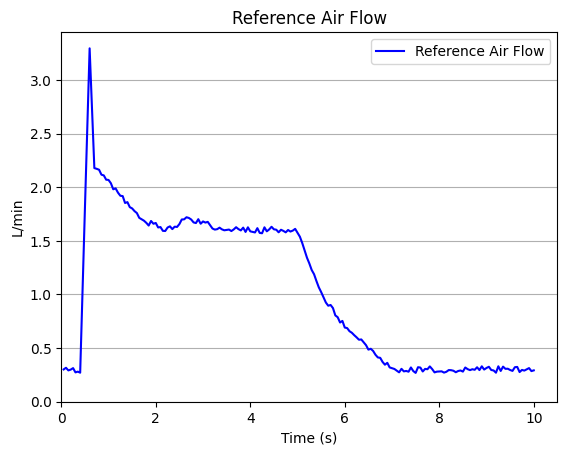

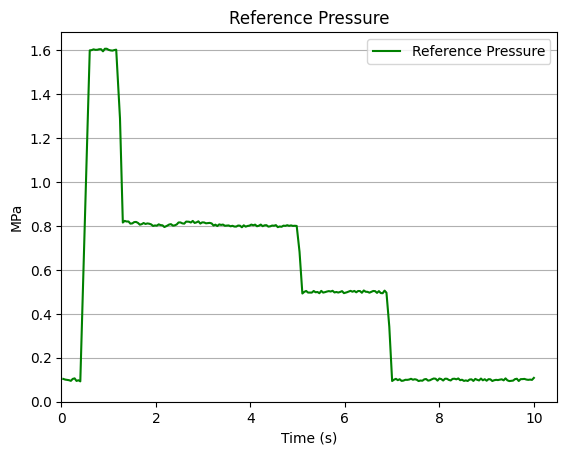

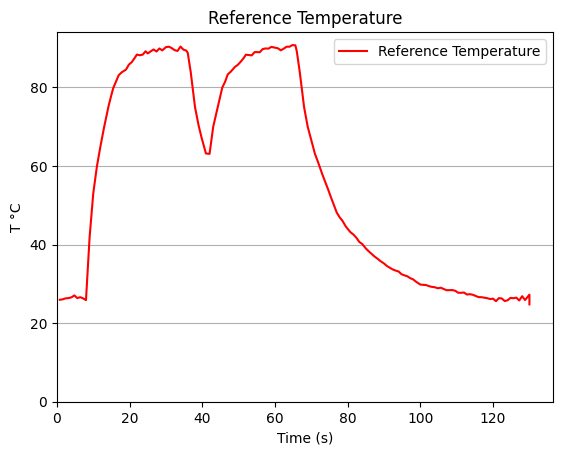

In [63]:
draw_reference_graphs()

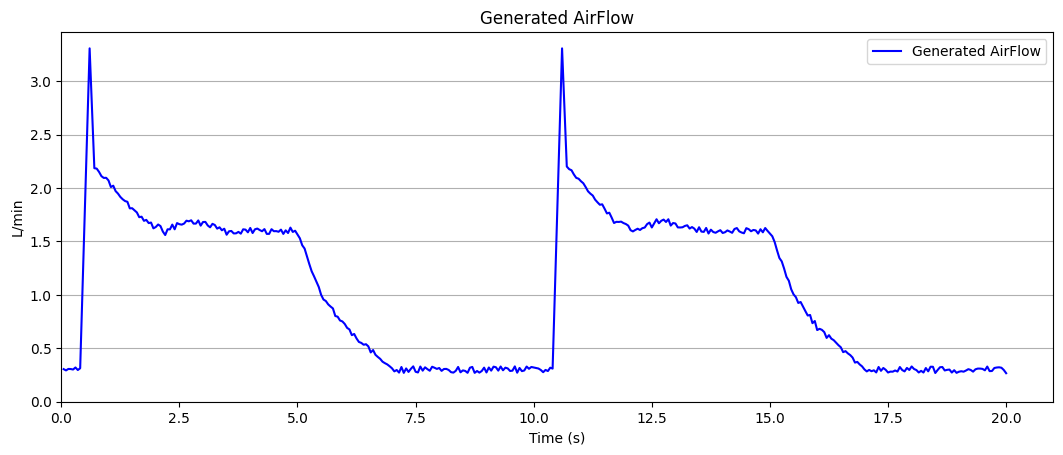

In [64]:

draw_values_graph(air_flow_values, 5, step = 0.05, noise_level = 0.05, func = interpolate_with_noise, type='flow', title="Generated AirFlow")